In [ ]:
# !pip install torchinfo
# !pip install torchmetrics
# !pip install torchsummary

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# from google.colab.patches import cv2_imshow as imshow

In [ ]:
# !unzip "/content/gdrive/MyDrive/Dataset.zip" -d "/content/gdrive/MyDrive/SAR_Dataset"

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import os
# import torchinfo

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Dataset

In [7]:
class SARData(Dataset):
    def __init__(self):
        
        self.xtrain_path = r"C:\Users\Kosh Rai\Desktop\Dataset\Dataset\img_dir" #Path to inputs
        self.ytrain_path = r"C:\Users\Kosh Rai\Desktop\Dataset\Dataset\ann_dir_8bit"#Path to labels

        self.xtrain_imgs = np.array(os.listdir(self.xtrain_path))[:5000]
        self.ytrain_imgs = np.array(os.listdir(self.ytrain_path))[:5000]
        self.num_classes = 5
        self.height, self.width = 256,256

    def process_label(self, label):
        r = []
        for i in range(self.num_classes):
            mask = label == i+1
            mask = mask.float()
            r.append(mask)
        return torch.stack(r)
    
    def __len__(self):
        return len(self.ytrain_imgs)
    
    def __getitem__(self, idx):        
        xtrain = cv.imread(f"{self.xtrain_path}/{self.xtrain_imgs[idx]}")
        xtrain = cv.cvtColor(xtrain, cv.COLOR_BGR2RGB)
        xtrain = torch.tensor(xtrain).permute(2,0,1) #HWC -> CHW
        
        ytrain = cv.imread(f"{self.ytrain_path}/{self.ytrain_imgs[idx]}", cv.IMREAD_GRAYSCALE)
        ytrain = torch.tensor(ytrain)
        processed_ytrain = self.process_label(ytrain)
        
        
        return xtrain, processed_ytrain 

In [5]:
def visualize_sample(img, label, title):
    fig, ax = plt.subplots(1, 6, figsize=(20,20))
    for i, subplot_ax in zip(range(data.num_classes + 1), ax.flatten()):
        if i == 0: 
            subplot_ax.imshow(img.permute(1,2,0))
            subplot_ax.set_title(title)
        else:
            subplot_ax.imshow(label[i-1], cmap='gray', vmin=0, vmax=1)
            subplot_ax.set_title(f'Label {i}')

def visualize_predictions(model, img):
    inp = (img - 127.5) / 255
    inp = torch.unsqueeze(inp, dim=0)
    pred = model(inp)
    visualize_sample(img, pred.squeeze().detach().numpy(), 'Model Predictions')

In [8]:
data = SARData()

### Network Architecture

In [ ]:
def double_conv(in_channels, out_channels):
    conv = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.Dropout2d(p=0.2),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1),
        nn.ReLU()
    )
    return conv

def double_Tconv(in_channels, out_channels):
    Tconv = nn.Sequential(
        nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1),
        nn.ReLU()
    )
    return Tconv

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.max_unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.conv1 = double_conv(3, 64)
        self.conv2 = double_conv(64, 128)
        self.conv3 = double_conv(128, 256)
        self.conv4 = double_conv(256, 512)
        self.conv5 = double_conv(512, 1024)
        self.Tconv5 = double_Tconv(1024, 512)
        self.Tconv4 = double_Tconv(512, 256)
        self.Tconv3 = double_Tconv(256, 128)
        self.Tconv2 = double_Tconv(128, 64)
        self.Tconv1 = double_Tconv(64, 5)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        self.bn4u = nn.BatchNorm2d(512)
        self.bn3u = nn.BatchNorm2d(256)
        self.bn2u = nn.BatchNorm2d(128)
        self.bn1u = nn.BatchNorm2d(64)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        c1 = self.conv1(x)
        c1 = self.bn1(c1)
        x1, i1 = self.max_pool(c1)

        c2 = self.conv2(x1)
        c2 - self.bn2(c2)
        x2, i2 = self.max_pool(c2)
        
        c3 = self.conv3(x2)
        c3 = self.bn3(c3)
        x3, i3 = self.max_pool(c3)

        c4 = self.conv4(x3)
        c4 = self.bn4(c4)
        x4, i4 = self.max_pool(c4)
        
        i = self.conv5(x4)
        
        t4 = self.Tconv5(i)
        
        t4 = self.bn4u(t4)
        z4 = self.max_unpool(t4, i4, output_size=c4.size())
        t3 = self.Tconv4(z4)
        
        t3 = self.bn3u(t3)
        z3 = self.max_unpool(t3, i3, output_size=c3.size())
        t2 = self.Tconv3(z3)
        
        t2 = self.bn2u(t2)
        z2 = self.max_unpool(t2, i2, output_size=c2.size())
        t1 = self.Tconv2(z2)
        
        t1 = self.bn1u(t1)
        z1 = self.max_unpool(t1, i1, output_size=c1.size())
        out = self.Tconv1(z1)
        
        return self.softmax(out)
        

In [ ]:
model = Network()
torchinfo.summary(model, (1,3,256,256))

### Training and Validation

In [9]:
epochs = 1
batch_size = 16
lr = 1e-2
momentum=0.9
train, val = torch.utils.data.random_split(data, [0.8, 0.2])

Training set pixel distribution


C:\Users\Kosh Rai\AppData\Local\Temp\ipykernel_10012\3322621969.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label)


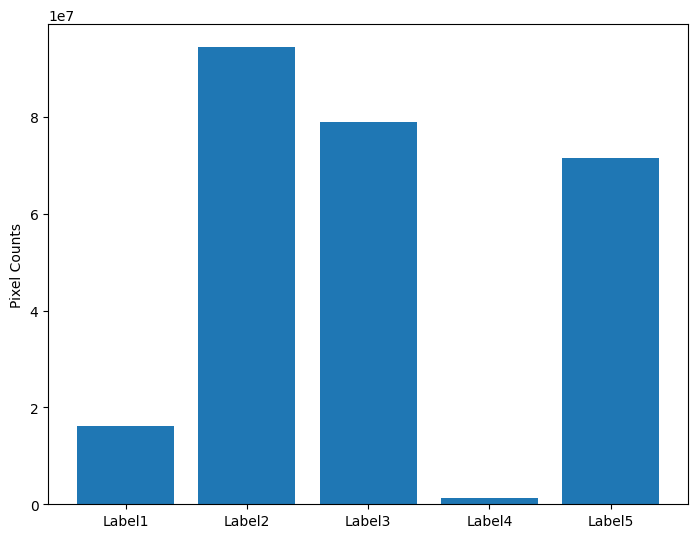

In [10]:
print('Training set pixel distribution')
count_1, count_2, count_3, count_4, count_5 = 0,0,0,0,0
for _ , label in train:
    label = torch.tensor(label)
    count_1 += (label[0] == 1).sum()
    count_2 += (label[1] == 1).sum()
    count_3 += (label[2] == 1).sum()
    count_4 += (label[3] == 1).sum()
    count_5 += (label[4] == 1).sum()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
counts = [count_1, count_2, count_3, count_4, count_5]
labels = ['Label1', 'Label2', 'Label3', 'Label4', 'Label5']
ax.bar(labels, counts)
plt.ylabel('Pixel Counts')
plt.savefig('train.png')
plt.show()

Validation set pixel distribution


C:\Users\Kosh Rai\AppData\Local\Temp\ipykernel_10012\1368463751.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label)


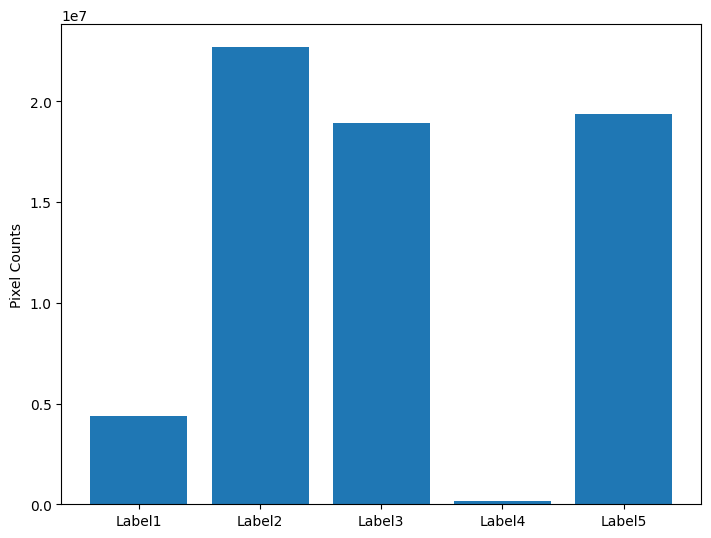

In [11]:
print('Validation set pixel distribution')
count_1, count_2, count_3, count_4, count_5 = 0,0,0,0,0
for _ , label in val:
    label = torch.tensor(label)
    count_1 += (label[0] == 1).sum()
    count_2 += (label[1] == 1).sum()
    count_3 += (label[2] == 1).sum()
    count_4 += (label[3] == 1).sum()
    count_5 += (label[4] == 1).sum()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
counts = [count_1, count_2, count_3, count_4, count_5]
labels = ['Label1', 'Label2', 'Label3', 'Label4', 'Label5']
ax.bar(labels, counts)
plt.ylabel('Pixel Counts')
plt.savefig('val.png')
plt.show()

In [ ]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

train, val = torch.utils.data.random_split(data, [0.8, 0.2])
train_size = len(train)
val_size = len(val)

print(f'Training with {train_size} images')
print(f'Validation with {val_size} images')

trainloader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val, batch_size=batch_size, shuffle=True, num_workers=2)

total_train_loss_hist = []
avg_train_loss_hist = []
total_val_loss_hist = []
avg_val_loss_hist = []



for epoch in range(epochs):
    print(f'{"-"*15}Epoch {epoch+1}/{epochs}{"-"*15}')
    
    total_train_loss = 0
    total_val_loss = 0
    
    #Training Loop
    model.train()
    for batch, (x,y) in enumerate(trainloader):
        x, y = x.to(device), y.to(device)
        x = (x - 127.5) / 255
        
        #Forward prop
        preds = model(x)
        loss = loss_fn(preds, y)
        total_train_loss += loss.item()
        
        #Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    #Validation loop
    model.eval()
    with torch.no_grad():
        for batch, (x,y) in enumerate(valloader):
            #Inference
            x, y = x.to(device), y.to(device)
            x = (x - 127.5) / 255
            preds = model(x)
            loss = loss_fn(preds, y)
            total_val_loss += loss.item()
        
        
    
    avg_train_loss = total_train_loss / train_size
    avg_val_loss = total_val_loss / val_size
    
    print(f"Avg Training Loss    : {avg_train_loss:<7f}")
    print(f"Avg Validation Loss  : {avg_val_loss:<7f}")
    
    total_train_loss_hist.append(total_train_loss)
    avg_train_loss_hist.append(avg_train_loss)
    total_val_loss_hist.append(total_val_loss)
    avg_val_loss_hist.append(avg_val_loss)

In [ ]:
plt.ylabel('Avg Loss per epoch')
plt.xlabel('Epochs')
plt.plot(avg_train_loss_hist, label='Avg Training Loss')
plt.plot(avg_val_loss_hist, label='Avg Validation Loss')
plt.legend()
plt.show()

In [ ]:
print('Images from the validation set')
idx = torch.randint(0, val_size, (5,))
model.to('cpu')
model.eval()
for i in (idx):
    img, label = val.__getitem__(i)
    visualize_sample(img, label, 'Ground Truth')
    visualize_predictions(model, img)

In [ ]:
print('Images from the training set')
idx = torch.randint(0, train_size, (5,))
model.to('cpu')
model.eval()
for i in (idx):
    img, label = train.__getitem__(i)
    visualize_sample(img, label, 'Ground Truth')
    visualize_predictions(model, img)

In [7]:
x = torch.rand(1,3,256,256)
y = torch.rand(1,3,256,256)
z = torch.cat((x,y), dim=1)

In [8]:
z.shape

torch.Size([1, 6, 256, 256])